In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.segmentation import find_boundaries
from skimage.feature import peak_local_max
from skimage.measure import regionprops

from tqdm import tqdm

# .mat processing

In [3]:
filepath = "data2.mat"
arrays = {}
f = h5py.File(filepath,'r')
for k, v in f.items():
    arrays[k] = np.array(v)

In [10]:
arrays.keys()

dict_keys(['Blabel', 'Wlabel', 'images', 'positions'])

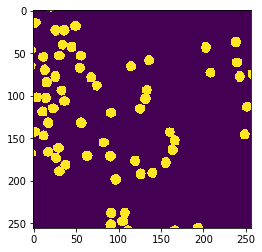

In [9]:
plt.imshow(arrays['Blabel'][:,:,:,0].reshape(256,256))

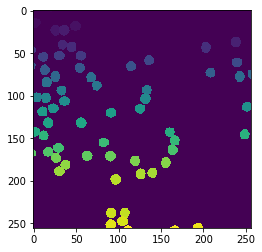

In [11]:
plt.imshow(arrays['Wlabel'][:,:,:,0].reshape(256,256))

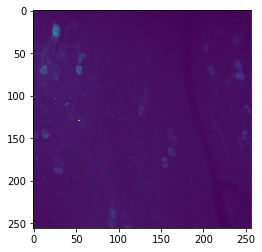

In [12]:
plt.imshow(arrays['images'][:,:,:,0].reshape(256,256))

In [16]:
arrays['positions']
# plt.imshow(arrays['positions'][:,:,:,0].reshape(256,256))

array([[517., 718., 265., ..., 719.,  25., 258.],
       [495., 340., 512., ..., 446., 184.,  13.],
       [  1.,   1.,   1., ...,  26.,  26.,  26.]])

In [18]:
# let's reshape the data to remove that unnecessary dimension

binary_labels = np.squeeze(arrays['Blabel'])
multi_labels = np.squeeze(arrays['Wlabel'])
images = np.squeeze(arrays['images'])
positions = arrays['positions']

In [2]:
# let's save these as individual h5 files so it not so memory intensive to load
def save_as_h5(filename,data):
    savePath = filename
    h5f = h5py.File(savePath, 'w')
    h5f.create_dataset('data', data=data)
    h5f.close()
    
# save_as_h5('binary_labels.h5',binary_labels)
# save_as_h5('multi_labels.h5', multi_labels)
# save_as_h5('full_images.h5', images)
# save_as_h5('full_positions.h5', positions)

# Segmentation

In [5]:
def load_h5(filename):
    h5f = h5py.File(filename,'r')
    data = h5f['data'][:]
    h5f.close()
    return data

binary_labels_w_overlap = load_h5("data/binary_labels.h5")
images = load_h5("data/full_images.h5")

In [7]:
print(binary_labels_w_overlap.shape)
print(images.shape)

(256, 256, 26000)
(256, 256, 26000)


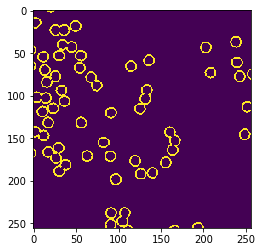

In [11]:
bounds = find_boundaries(binary_labels_w_overlap[:,:,0])
plt.imshow(bounds)

In [5]:
## watershed

# watershed alg
multi_labels_no_overlap = np.zeros_like(binary_labels_w_overlap)
binary_labels_no_overlap = np.zeros_like(binary_labels_w_overlap)
for i in tqdm(range(binary_labels_w_overlap.shape[2])):
    distance = ndi.distance_transform_edt(binary_labels_w_overlap[:,:,i])
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)),
                              labels=binary_labels_w_overlap[:,:,i])

    markers = ndi.label(local_maxi)[0]
    multi_labels_no_overlap[:,:,i] = watershed(-distance, markers, mask=binary_labels_w_overlap[:,:,i], 
                                               watershed_line=True)
    
# make it binary
binary_labels_no_overlap[multi_labels_no_overlap >= 1] = 1

# save
save_as_h5('binary_labels_no_overlap.h5', binary_labels_no_overlap)
save_as_h5('multi_labels_no_overlap.h5', multi_labels_no_overlap)

100%|██████████| 26000/26000 [04:55<00:00, 87.90it/s]


In [3]:
binary_labels_no_overlap = load_h5("data/binary_labels_no_overlap.h5")
multi_labels_no_overlap = load_h5("data/multi_labels_no_overlap.h5")

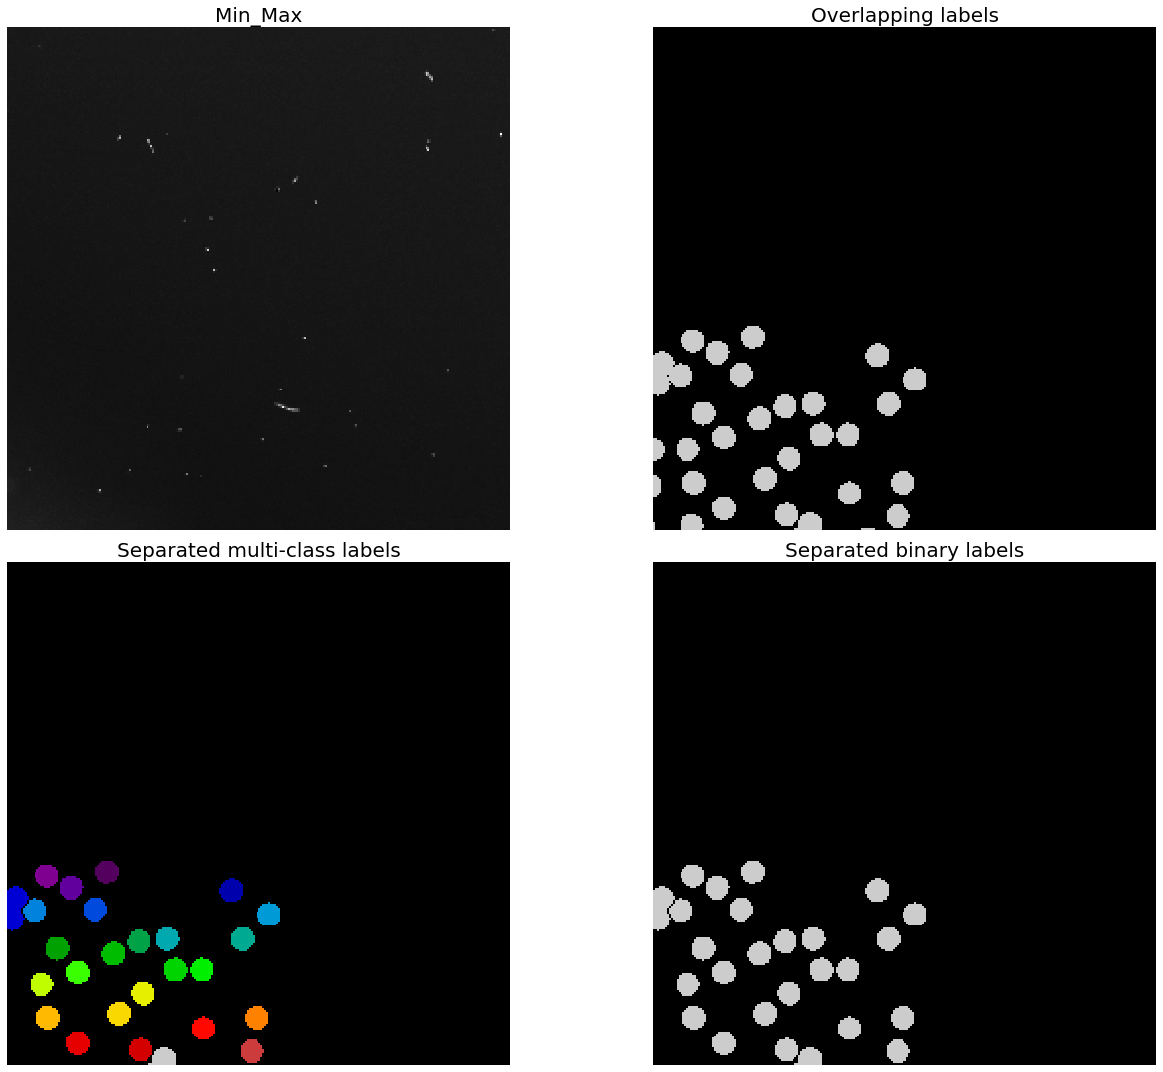

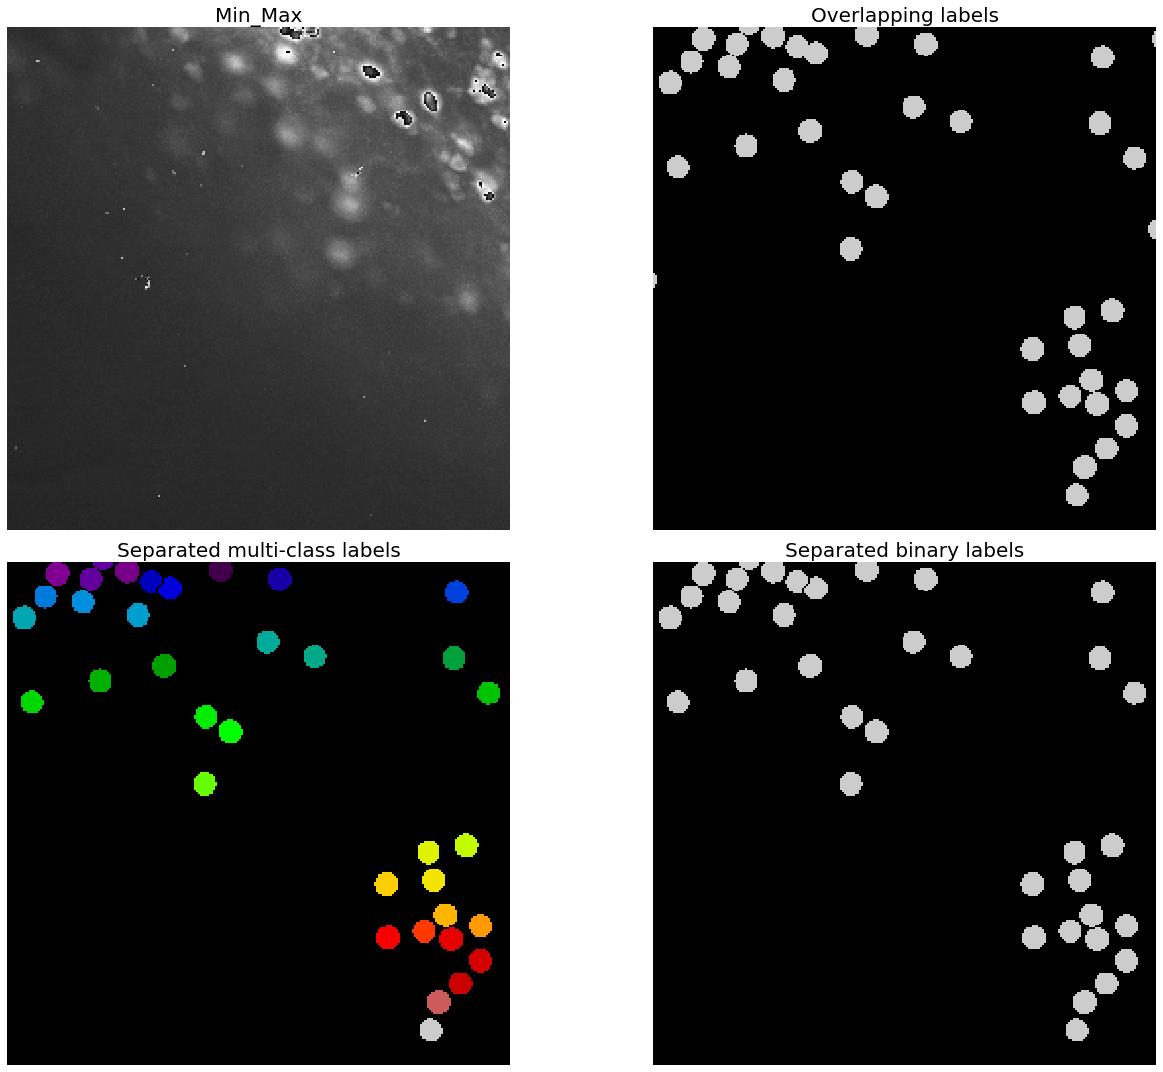

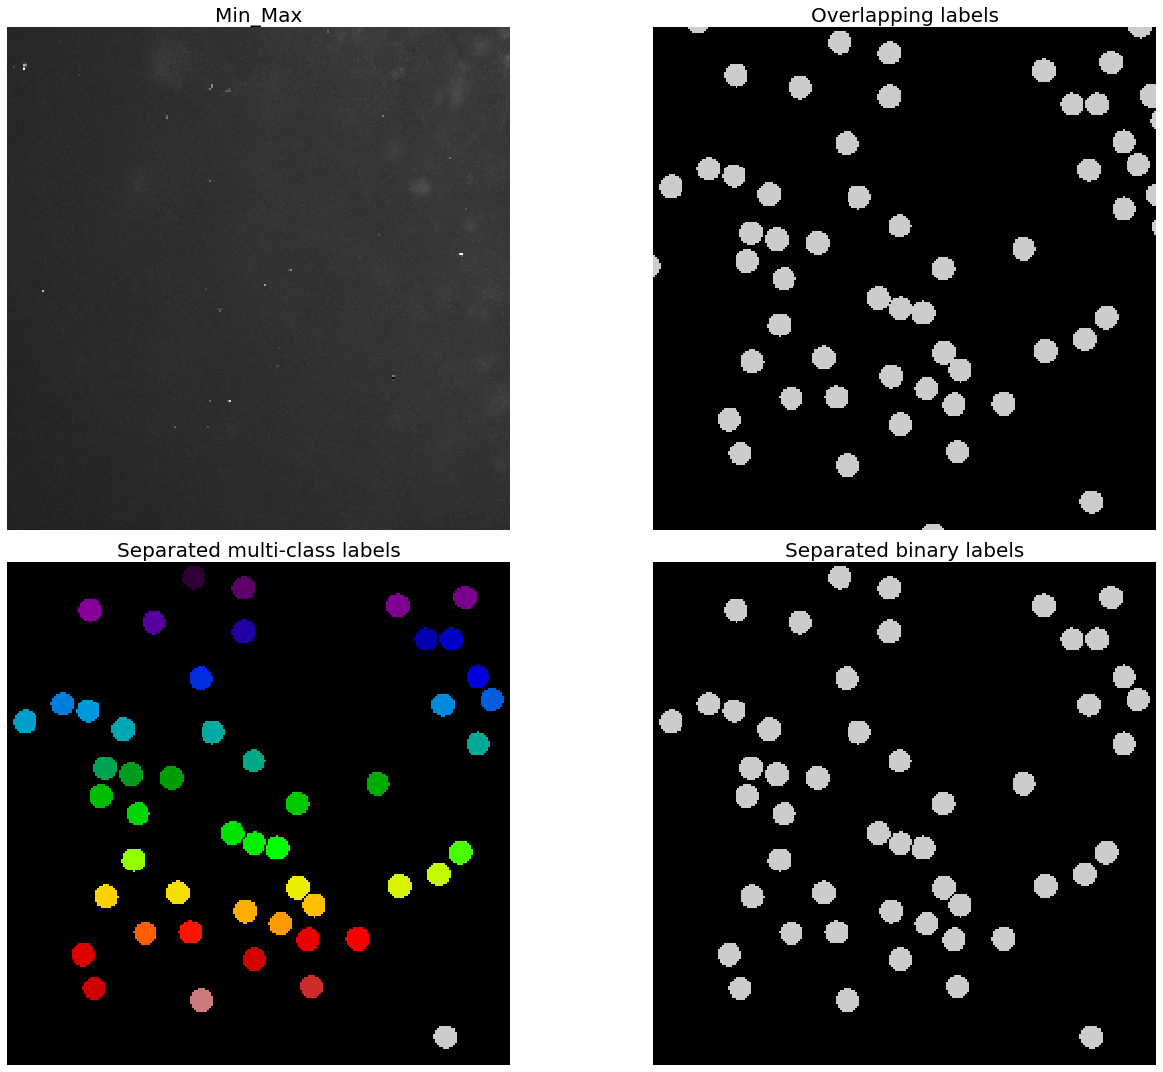

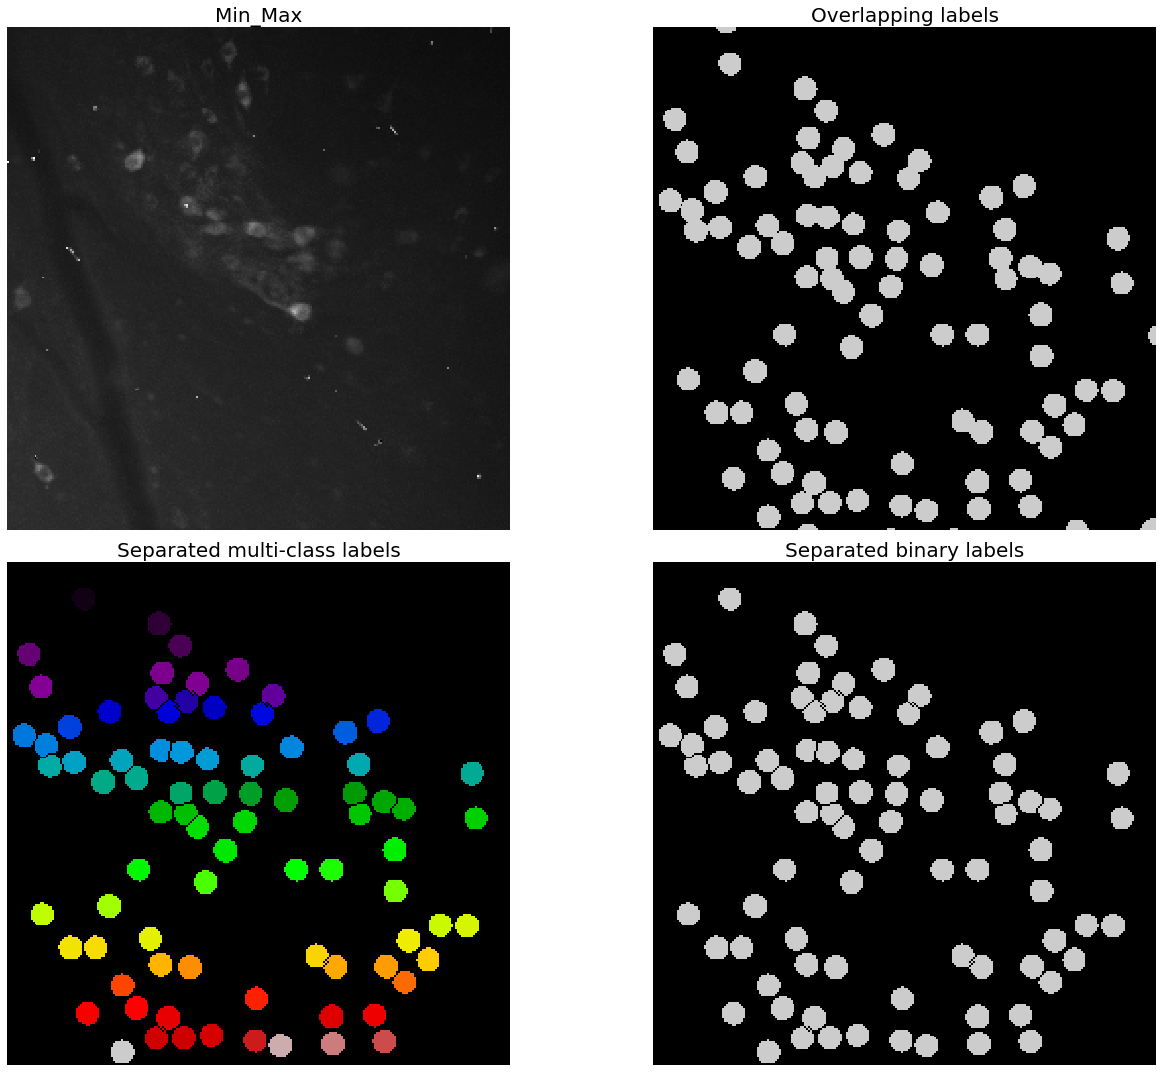

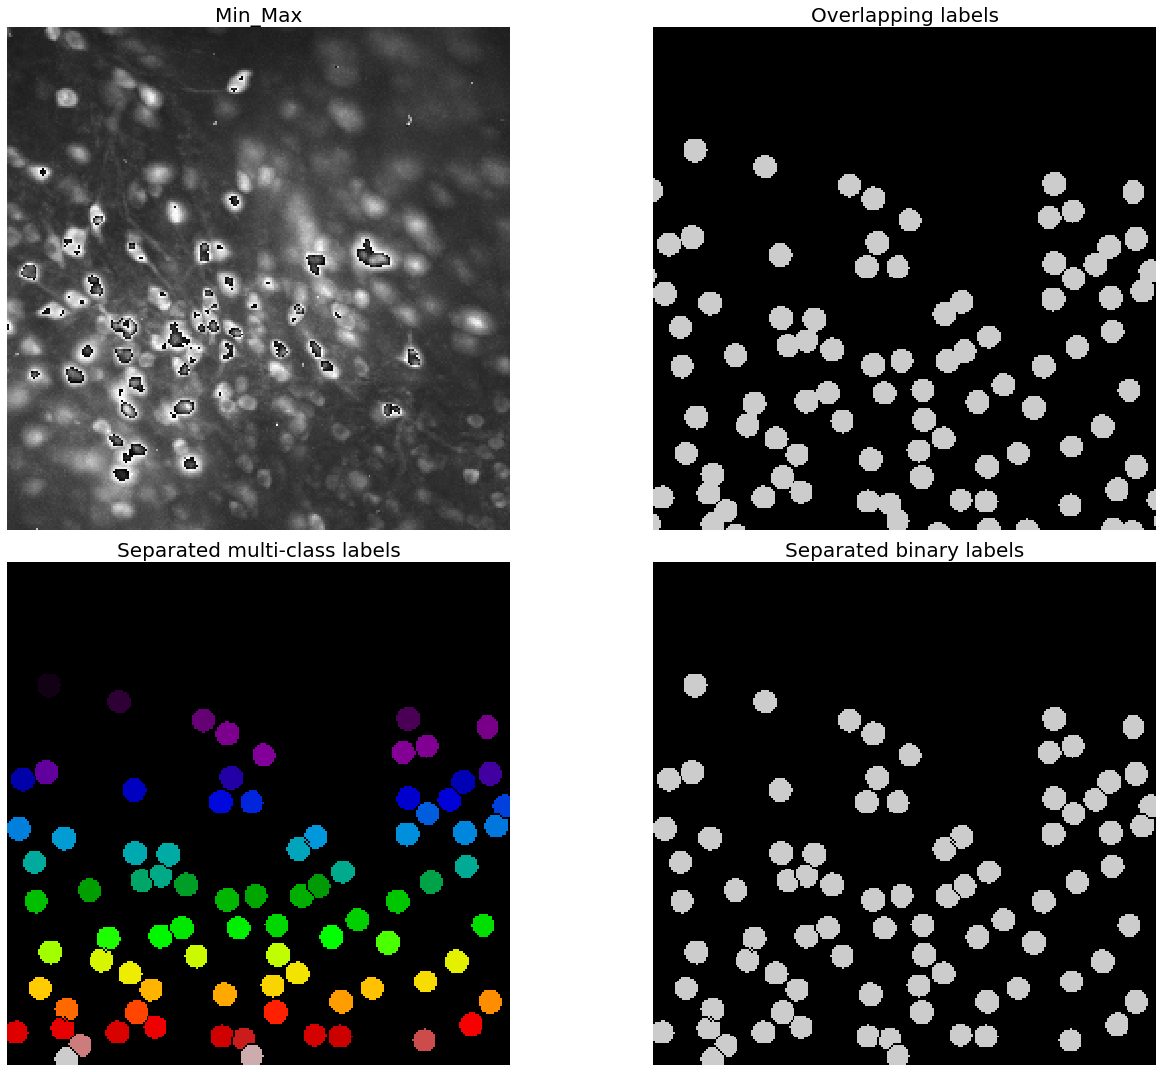

In [13]:
## plot

for i in range(5):

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15), sharex=True, sharey=True)
    ax = axes.ravel()

    idx = np.random.randint(low=0,high=binary_labels_no_overlap.shape[2])

    alpha, beta = 10, 100
    fs = 20 # font size

    ax[0].imshow(alpha*images[:,:,idx] + beta, cmap='gray', )
    ax[0].set_title('Min_Max', fontsize=fs)
    ax[1].imshow(binary_labels_w_overlap[:,:,idx], cmap=plt.cm.nipy_spectral)
    ax[1].set_title('Overlapping labels', fontsize=fs)
    ax[2].imshow(multi_labels_no_overlap[:,:,idx], cmap=plt.cm.nipy_spectral)
    ax[2].set_title('Separated multi-class labels', fontsize=fs)
    ax[3].imshow(binary_labels_no_overlap[:,:,idx], cmap=plt.cm.nipy_spectral)
    ax[3].set_title('Separated binary labels', fontsize=fs)

    for a in ax:
        a.set_axis_off()

    fig.tight_layout()
    img_name = "images/pres/" + "img"+ str(idx) + ".png"
    fig.savefig(img_name)
    plt.show()
    print('')
    print('')
    print('')
    print('')
    print('')
        

## Find label centroids

In [25]:
# load multi-class labels without overlap
multi_labels_no_overlap = load_h5("data/multi_labels_no_overlap.h5")

In [26]:
multi_labels_no_overlap.shape

(256, 256, 26000)

In [83]:
# find centroids

def find_centroids(img):
    # finds centroids of multi_class image
    props = measure.regionprops(img)
    cent = []
    for i in range(np.unique(img).shape[0]-1):
        cent.append(props[i].centroid)
    return np.array(cent)

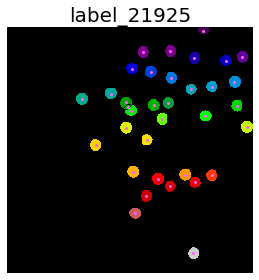

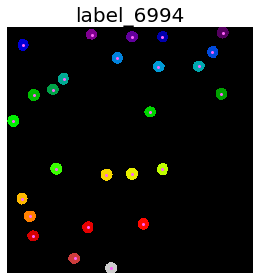

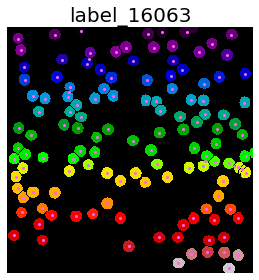

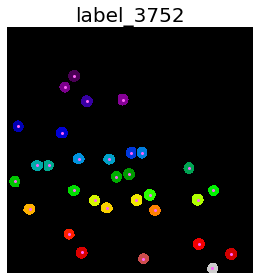

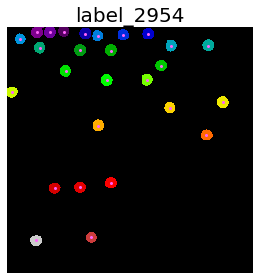

In [106]:
# plot label with centroids
for i in range(5):

    fig, ax = plt.subplots(figsize=(4, 4), sharex=True, sharey=True)
    fs = 20 # font size
    
    # get random image
    idx = np.random.randint(low=0,high=binary_labels_no_overlap.shape[2])
    img = multi_labels_no_overlap[:,:,idx]
    
    # find centroid
    cent = find_centroids(img)

    ax.imshow(img, cmap=plt.cm.nipy_spectral)
    ax.scatter(cent[:,1],cent[:,0], c='#ff63fa', s=4)
    title_string = "label_{idx}".format(idx = idx)
    ax.set_title(title_string, fontsize=fs)

    ax.set_axis_off()

    fig.tight_layout()
#     img_name = "images/centroids/" + title_string + ".png"
    fig.savefig(img_name)
    plt.show()
    print('')
    print('')


In [57]:
## watershed

# watershed alg
multi_labels_no_overlap = np.zeros_like(binary_labels_w_overlap)
binary_labels_no_overlap = np.zeros_like(binary_labels_w_overlap)
for i in tqdm(range(5)):
    distance = ndi.distance_transform_edt(binary_labels_w_overlap[:,:,i])
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)),
                              labels=binary_labels_w_overlap[:,:,i])

    markers = ndi.label(local_maxi)[0]
    multi_labels_no_overlap[:,:,i] = watershed(-distance, markers, mask=binary_labels_w_overlap[:,:,i],
                                              watershed_line=True)
    
# make it binary
binary_labels_no_overlap[multi_labels_no_overlap >= 1] = 1

# save
# save_as_h5('binary_labels_no_overlap.h5', binary_labels_no_overlap)
# save_as_h5('multi_labels_no_overlap.h5', multi_labels_no_overlap)

100%|██████████| 5/5 [00:00<00:00, 93.91it/s]


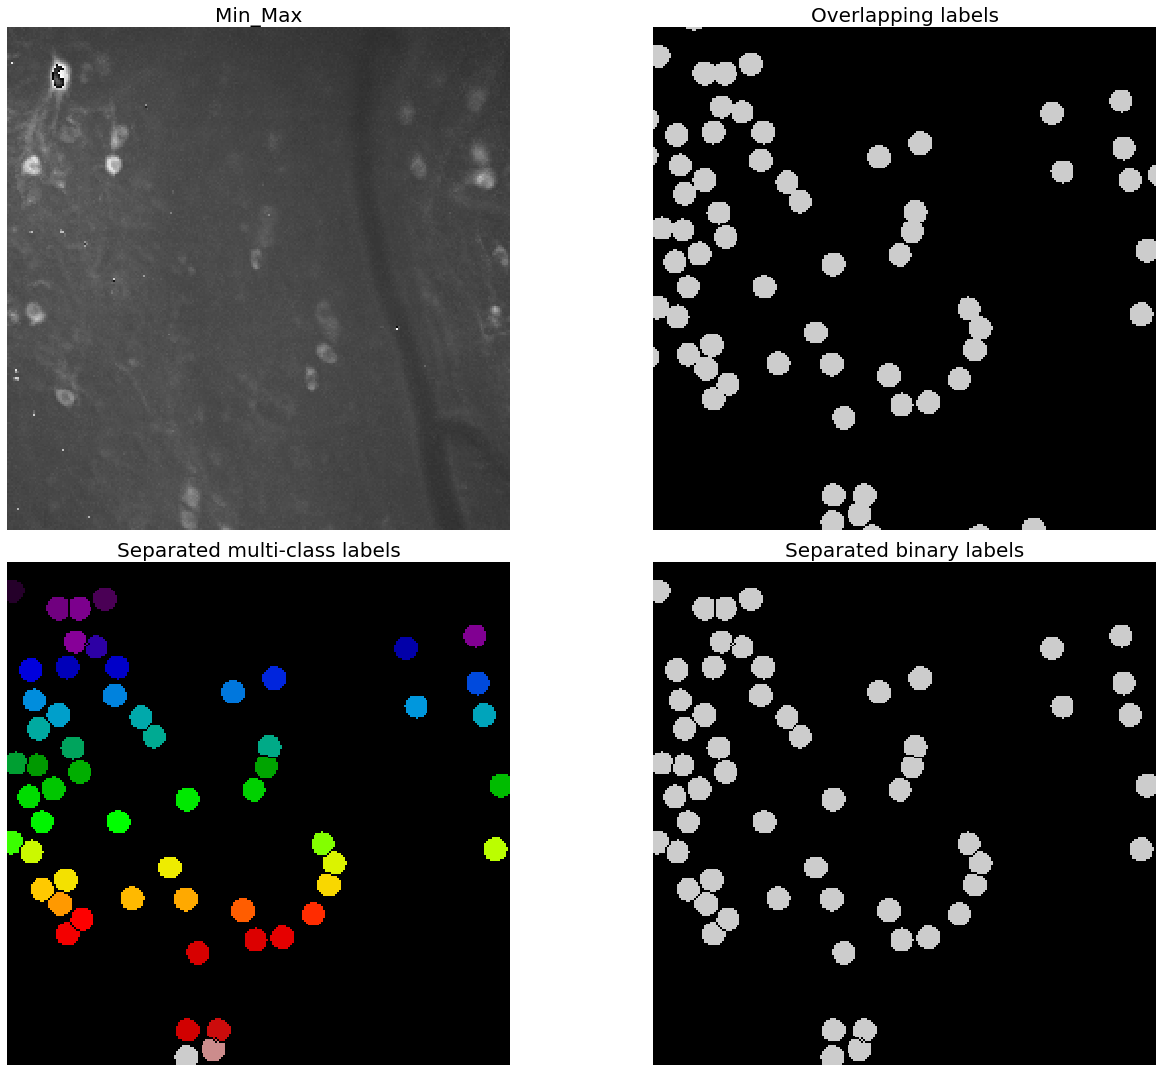

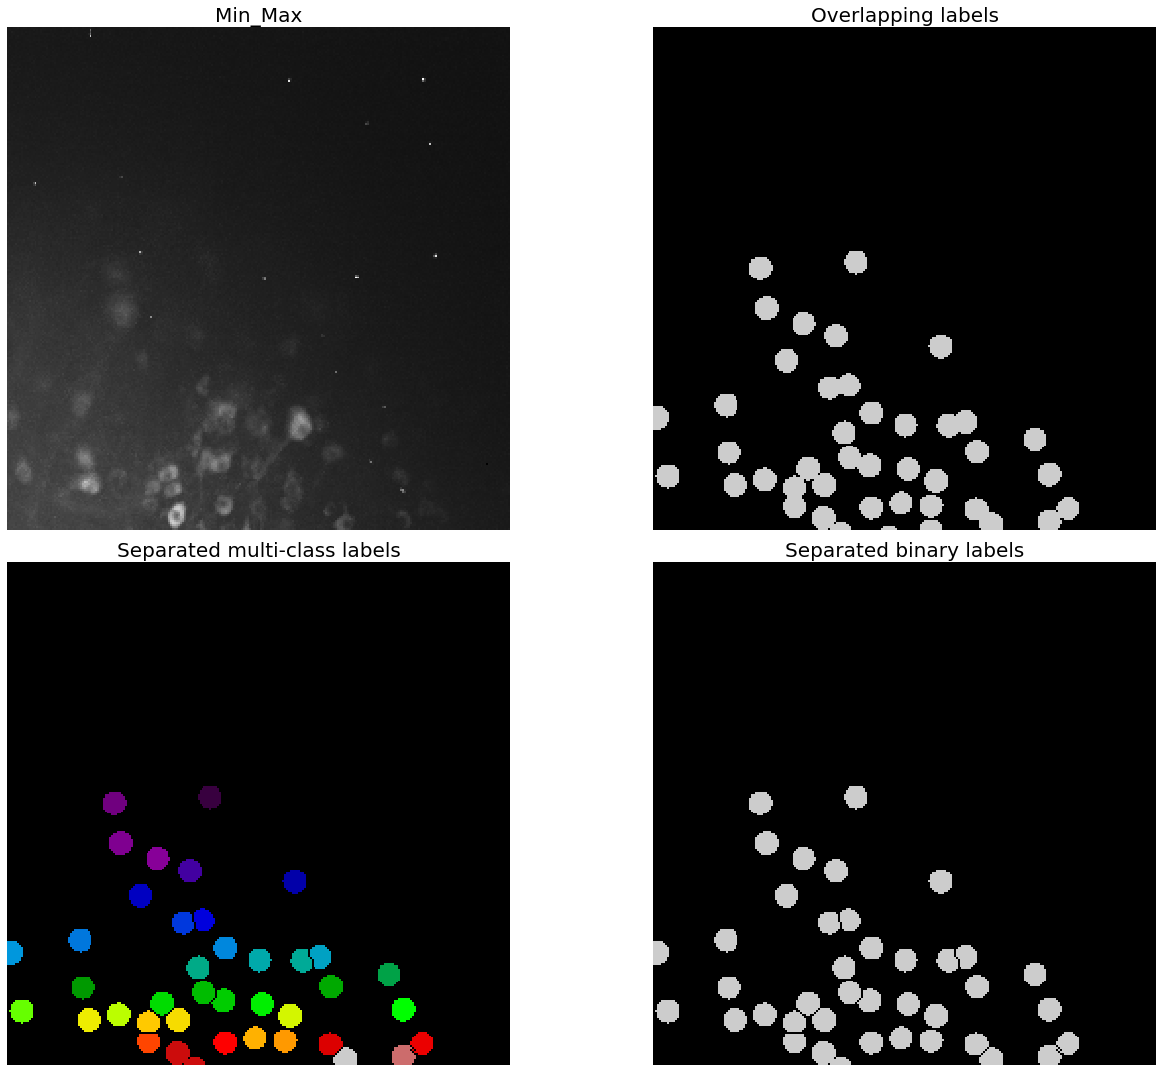

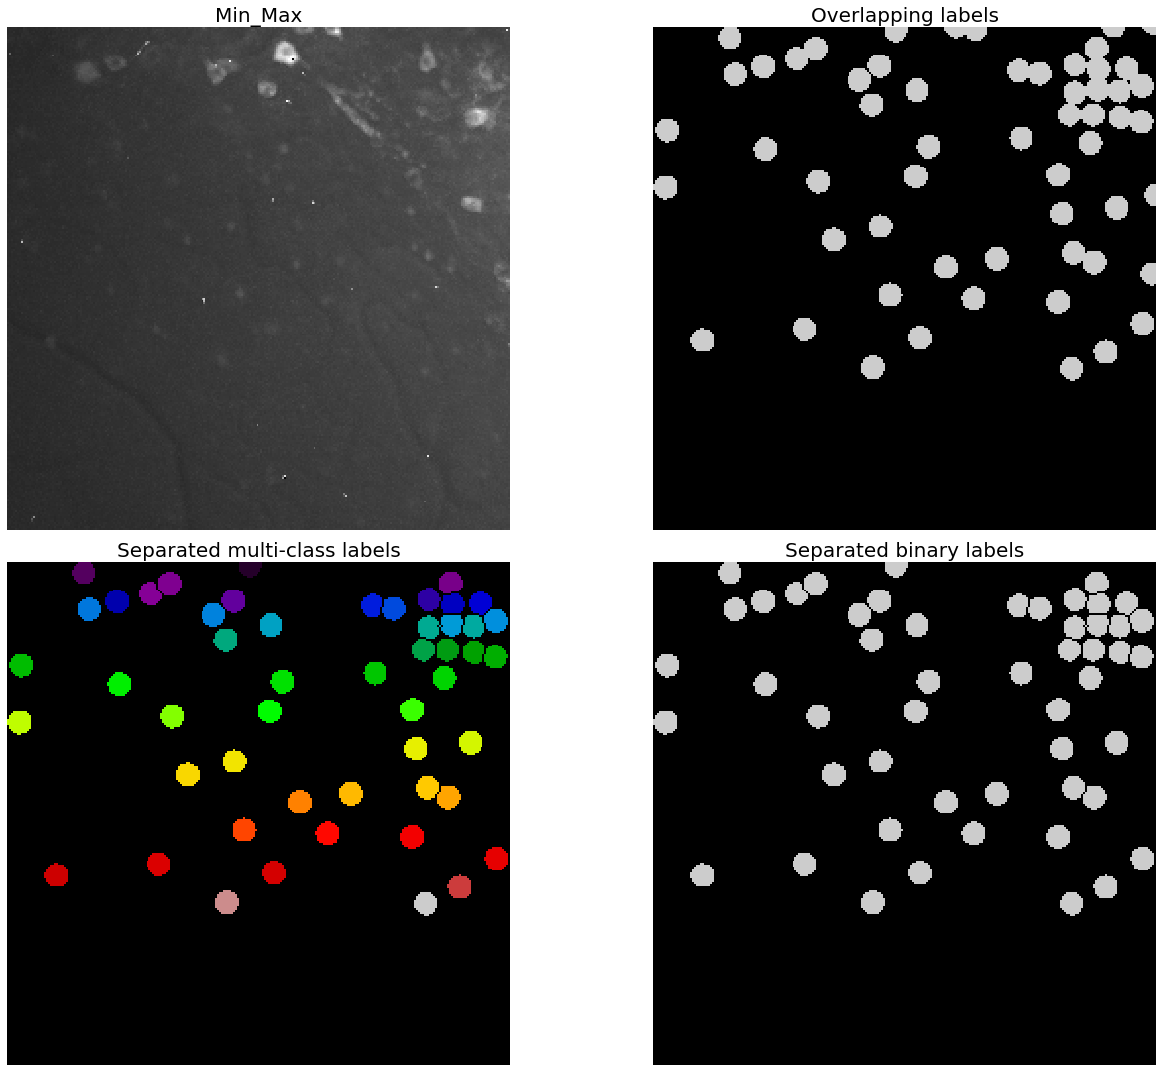

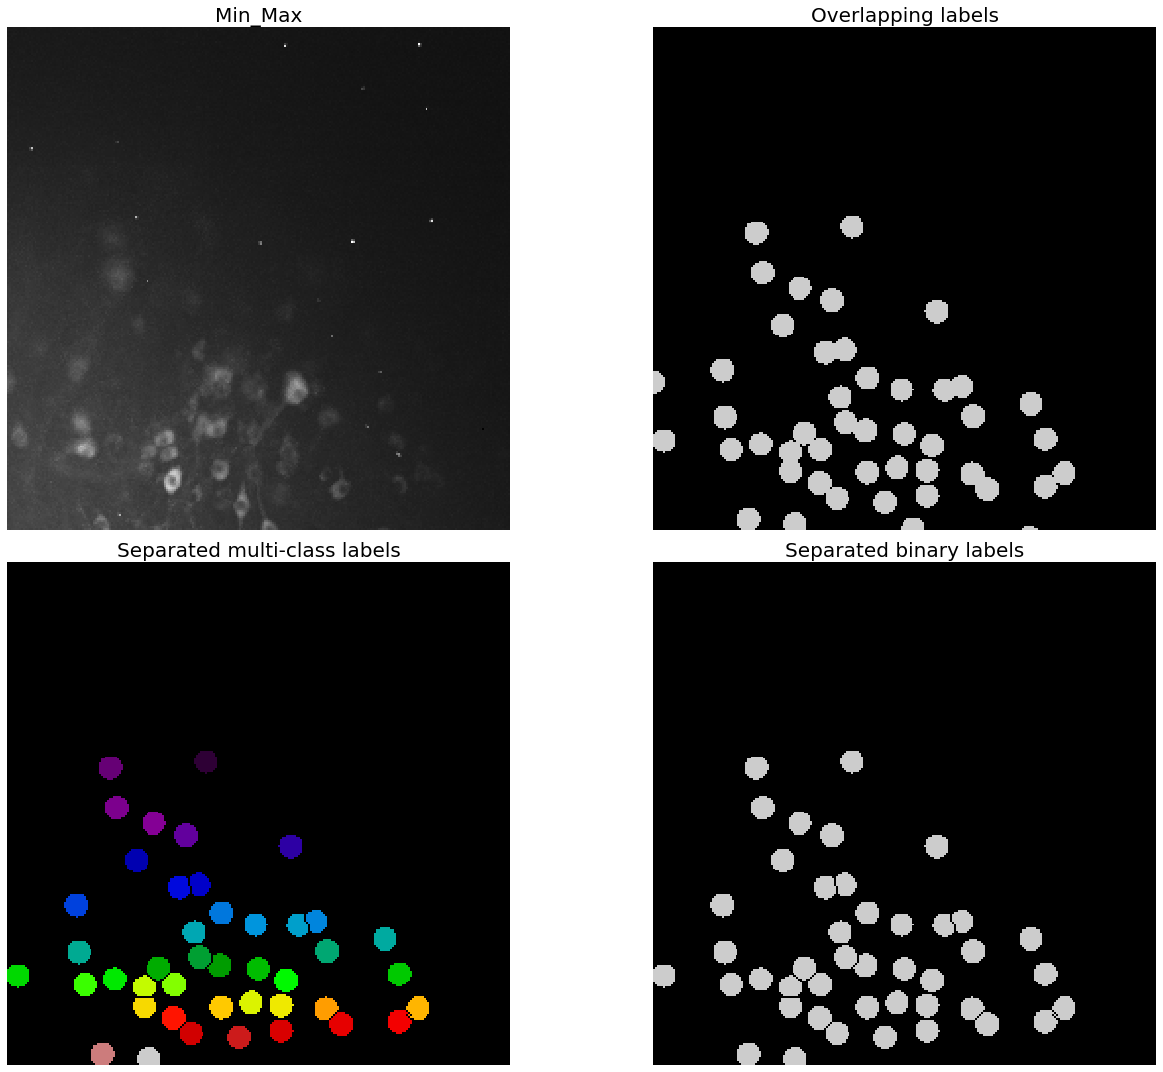

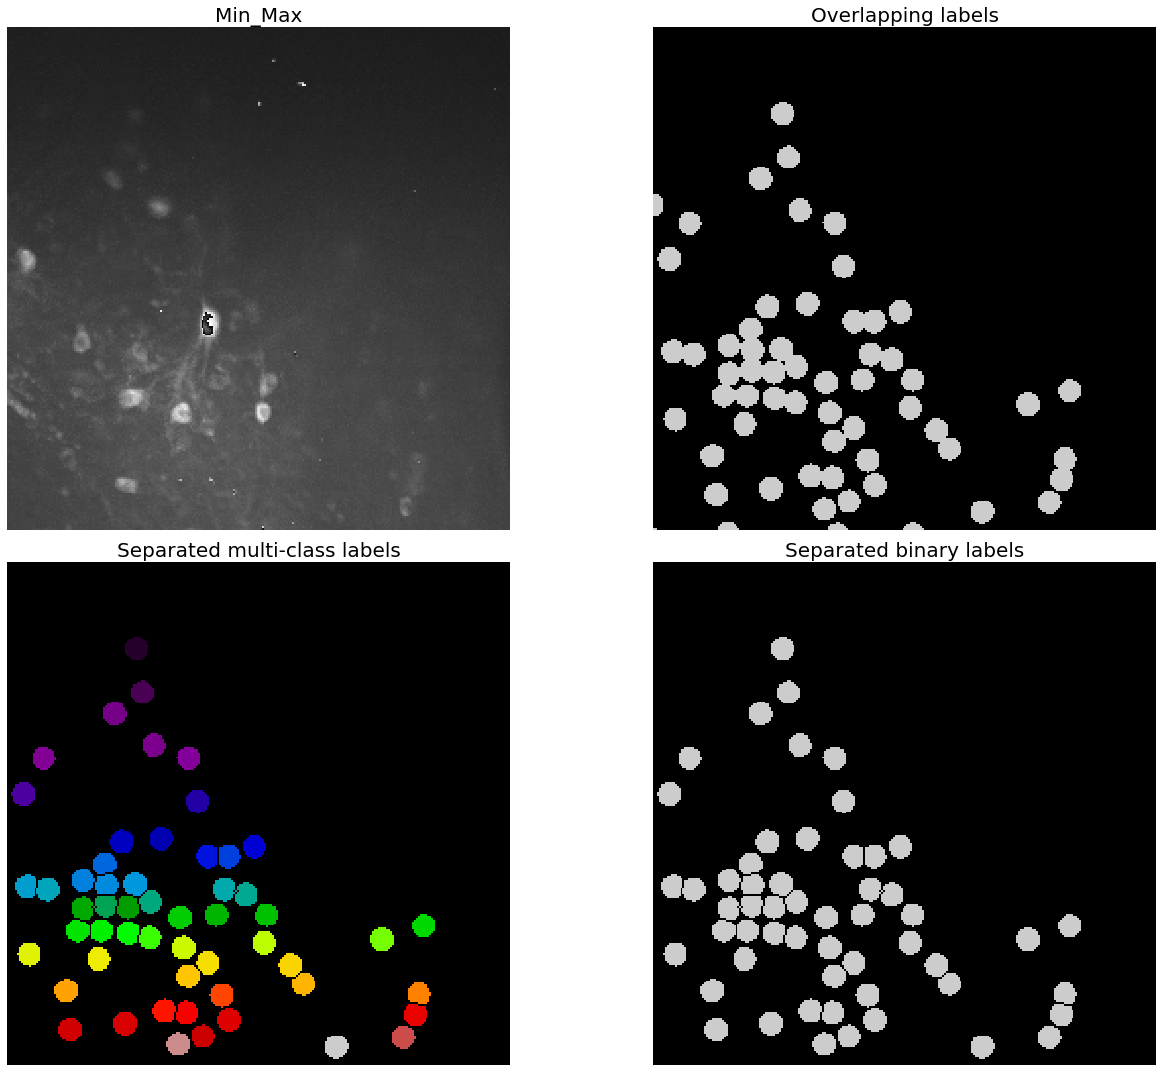

In [58]:
## plot

for i in range(5):

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15), sharex=True, sharey=True)
    ax = axes.ravel()

    idx = i

    alpha, beta = 10, 100
    fs = 20 # font size

    ax[0].imshow(alpha*images[:,:,idx] + beta, cmap='gray', )
    ax[0].set_title('Min_Max', fontsize=fs)
    ax[1].imshow(binary_labels_w_overlap[:,:,idx], cmap=plt.cm.nipy_spectral)
    ax[1].set_title('Overlapping labels', fontsize=fs)
    ax[2].imshow(multi_labels_no_overlap[:,:,idx], cmap=plt.cm.nipy_spectral)
    ax[2].set_title('Separated multi-class labels', fontsize=fs)
    ax[3].imshow(binary_labels_no_overlap[:,:,idx], cmap=plt.cm.nipy_spectral)
    ax[3].set_title('Separated binary labels', fontsize=fs)

    for a in ax:
        a.set_axis_off()

    fig.tight_layout()
    img_name = "images/pres/" + "img"+ str(idx) + ".png"
    fig.savefig(img_name)
    plt.show()
    print('')
    print('')
    print('')
    print('')
    print('')
        

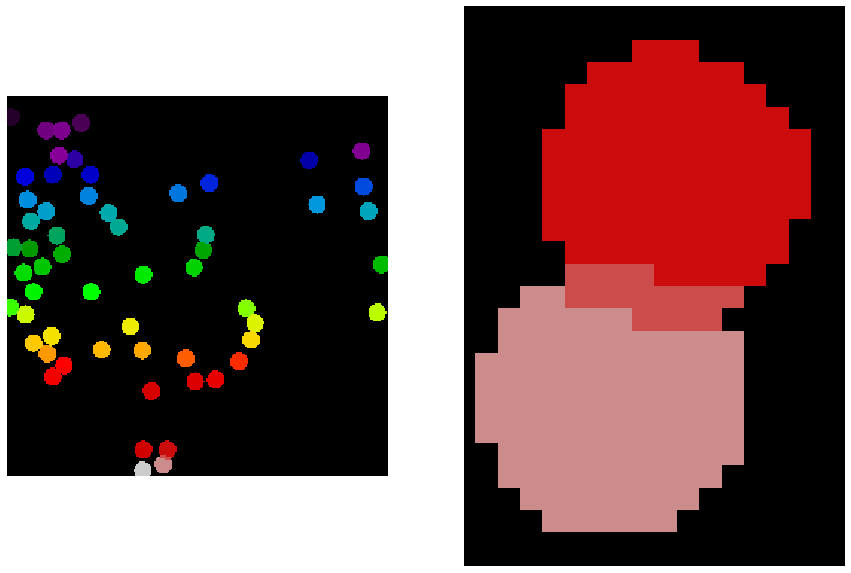

In [56]:
fig, axs = plt.subplots(1, 2, figsize=(15,15))
for a in axs:
    a.set_axis_off()

axs[0].imshow(multi_labels_no_overlap[:,:,0], cmap=plt.cm.nipy_spectral)
axs[1].imshow(multi_labels_no_overlap[:,:,0], cmap=plt.cm.nipy_spectral)
axs[1].set_ylim(255, 230)
axs[1].set_xlim(98,115)
for a in axs:
    a.set_axis_off()
    
fig.savefig('images/pres/overlaps.png')
    
plt.show()